In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

ModuleNotFoundError: No module named 'sklearn'

In [2]:
tab_count = pd.read_csv("toden/toden_counts.txt", sep="\t")
tab_meta = pd.read_excel("toden/toden_metadata.xlsx")

In [3]:
# Normalization: standard scale

def PreProcessNumerical(df, dfFit, columnNames):
    scaler = StandardScaler()
    scaler.fit(dfFit[columnNames])
    df[columnNames] = scaler.transform(df[columnNames])
    return df

In [4]:
# normalize count data
preTrain = tab_count.copy()
Train = PreProcessNumerical(preTrain, preTrain, preTrain.columns)

In [5]:
# Fill out 'None' in the columns ['Apoe.status','apoe_carrier','apoe_dose']
li = ['Age','Gender','Center','Disease']
share_feat = ['Apoe.status','apoe_carrier','apoe_dose']
estimate_meta = tab_meta[li].copy()
for i in ['Gender','Center','Disease']:
    le = LabelEncoder()
    le.fit(estimate_meta[i])
    estimate_meta[i] = le.transform(tab_meta[i])

share_col = []
for var in share_feat:
    temp = estimate_meta.copy()
    le = LabelEncoder()
    le.fit(tab_meta[var])
    a = le.transform(tab_meta[var])
    a = np.where(a==le.transform(['None'])[0], np.nan, a)
    temp[var] = a

    imputer = KNNImputer(n_neighbors=1)
    impute_data = imputer.fit_transform(temp)
    temp = pd.DataFrame(impute_data, columns=['Age','Gender','Center','Disease',var])

    temp[var] = [int(i) for i in temp[var]]
    temp[var] = le.inverse_transform(temp[var])
    share_col.append(list(temp[var]))

In [6]:
# df1: standard-scaled count
# df2: standarad-scaled count + share_feat(apoe status, carrier, dose)

df1 = Train.T
df2 = df1.copy()
for i in range(len(share_feat)):
    le = LabelEncoder()
    le.fit(share_col[i])
    a = le.transform(share_col[i])
    df2[share_feat[i]] = a

In [7]:
y = tab_meta['Disease']
ma = {'NCI': 0, 'AD': 1}
for i in range(len(y)):
    y.iloc[i] = ma[y.iloc[i]]

/var/folders/z0/gtt3z07d02n_lrzk3xy2qv0w0000gn/T/ipykernel_70138/2986897895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.iloc[i] = ma[y.iloc[i]]


In [8]:
train_input=['normalized count', 'normalized count + apoe info']
train_data = [df1, df2]
for i in range(len(train_data)):
    dTrain = train_data[i]
    roc_score = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(XTrain, list(yTrain))

        pred = clf.predict(XVal)
        roc_score.append(roc_auc_score(list(yVal), clf.predict_proba(XVal)[:,1]))
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")


Train: normalized count, mean val AUC: 0.6945207992359049
Train: normalized count + apoe info, mean val AUC: 0.7068519815141971


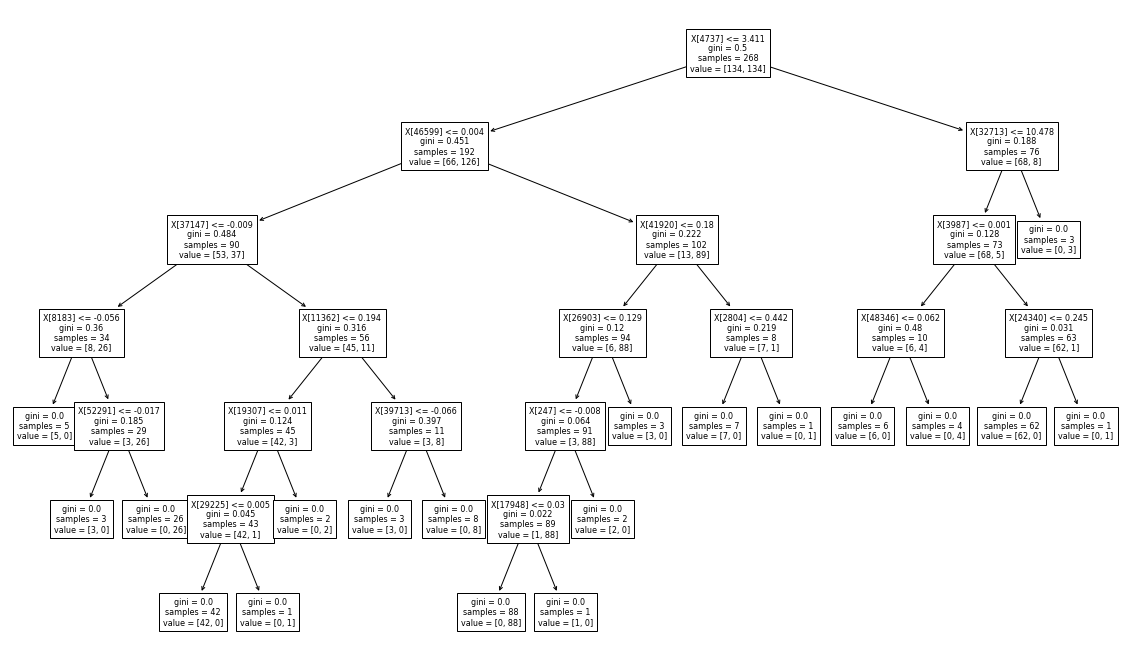

In [9]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=8)
plt.show()

In [35]:
# GaussianNB approach
for i in range(len(train_data)):
    dTrain = train_data[i]
    roc_score = []
    for k,(trainInd, valInd) in enumerate(KFold(shuffle=True,random_state=16).split(dTrain)):
        XTrain = dTrain.iloc[trainInd,]
        yTrain = y.iloc[trainInd,]
        XVal = dTrain.iloc[valInd,]
        yVal = y.iloc[valInd,]
        gnb = GaussianNB()
        gnb.fit(XTrain, yTrain.astype(int))
        pred = gnb.predict(XVal)
        roc_score.append(roc_auc_score(list(yVal), gnb.predict_proba(XVal)[:,1]))
    print(f"Train: {train_input[i]}, mean val AUC: {sum(roc_score)/len(roc_score)}")

Train: normalized count, mean val AUC: 0.6396282619640521
Train: normalized count + apoe info, mean val AUC: 0.6396282619640521


In [9]:
# Validation on other two datasets

tab1 = pd.read_csv("silver_seq/silver_seq_counts.txt", sep="\t")
tab2 = pd.read_csv("burgos_dbgap/burgos_dbgap_counts.txt", sep="\t")
